# Downloading Market and Fundamental Data with `yfinance`

## Imports & Settings

In [3]:
import pandas as pd
import yfinance as yf
# hello

In [4]:
data = yf.download(
        tickers = "SPY AAPL MSFT", # list or string

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5d",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "60m",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%%**********************]  3 of 3 completed


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2024-04-15 04:00:00 to 2024-04-19 19:00:00
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (MSFT, Open)    85 non-null     float64
 1   (MSFT, High)    85 non-null     float64
 2   (MSFT, Low)     85 non-null     float64
 3   (MSFT, Close)   85 non-null     float64
 4   (MSFT, Volume)  85 non-null     int64  
 5   (AAPL, Open)    85 non-null     float64
 6   (AAPL, High)    85 non-null     float64
 7   (AAPL, Low)     85 non-null     float64
 8   (AAPL, Close)   85 non-null     float64
 9   (AAPL, Volume)  85 non-null     int64  
 10  (SPY, Open)     85 non-null     float64
 11  (SPY, High)     85 non-null     float64
 12  (SPY, Low)      85 non-null     float64
 13  (SPY, Close)    85 non-null     float64
 14  (SPY, Volume)   85 non-null     int64  
dtypes: float64(12), int64(3)
memory usage: 10.6 KB


In [6]:
# auto_adjust = True
data['SPY']

Price,Open,High,Low,Close,Volume
Datetime,,,,,
2024-04-15 04:00:00,513.630000,513.880000,512.610000,513.380000,0
2024-04-15 05:00:00,513.390000,513.800000,512.810000,512.930000,0
2024-04-15 06:00:00,512.940000,513.440000,512.790000,512.870000,0
2024-04-15 07:00:00,512.890000,513.780000,512.380000,513.580000,0
2024-04-15 08:00:00,513.590000,513.980000,512.150000,513.797000,0
...,...,...,...,...,...
2024-04-19 15:30:00,495.079987,495.519989,493.859985,495.100006,15919503
2024-04-19 16:00:00,495.090000,495.350000,494.700000,495.100000,0
2024-04-19 17:00:00,495.040000,495.160000,479.910700,494.900000,0


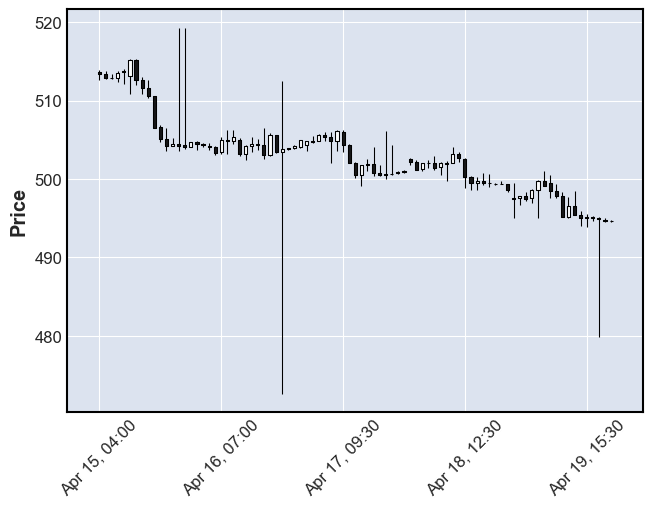

In [8]:
# plot the candlesticks for SPY
import mplfinance as mpf
mpf.plot(data['SPY'], type='candle')


In [9]:
len(data['SPY']['Close'])

85

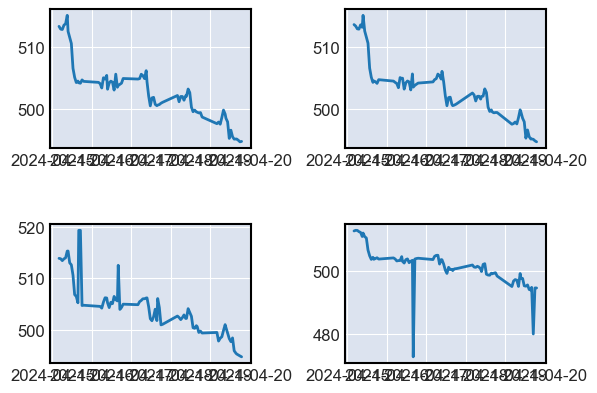

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2)
plt.tight_layout(pad=3.0)
ax[0,0].plot(data['SPY']['Close'])
ax[0,1].plot(data['SPY']['Open'])
ax[1,0].plot(data['SPY']['High'])
ax[1,1].plot(data['SPY']['Low'])

In [15]:
# Now I build an RNN that predicts high price of SPY given the high price, close, open and low at a previous time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# Set the hyperparameters
input_size = 4  # Number of input features (high price, close, open, low)
hidden_size = 32  # Number of hidden units in the RNN layer
output_size = 1  # Number of output units (predicted high price)

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_data = np.array([data['SPY']['Close'], data['SPY']['Open'], data['SPY']['High'], data['SPY']['Low']]).T
print(np.shape(input_data))
print(np.shape(target_data))
target_data = data['SPY']['High'][1:]
# Convert the input data to tensors
input_data = torch.tensor(input_data, dtype=torch.float32)
target_data = torch.tensor(target_data, dtype=torch.float32)



(85, 4)
torch.Size([84])


C:\Users\user\AppData\Local\Temp\ipykernel_2456\3157143369.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_data = torch.tensor(target_data, dtype=torch.float32)


In [17]:
# Train the RNN model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    output = model(input_data)
    loss = criterion(output, target_data)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



IndexError: too many indices for tensor of dimension 2

In [ ]:
# Make predictions using the trained model
predicted_high = model(input_data)